In [ ]:
#!pip install geneticalgorithm

In [1]:
import numpy as np
import pandas as pd
import geneticalgorithm as ga
import random as rand
import numpy.random as rand_2
import matplotlib.pyplot as plt

### Подготовка данных

In [2]:
# data preparation
cities = pd.DataFrame(data={
    "Magnitogorsk": [53.2300, 59.0200],
    "BuenosAires": [-34.3559, -58.2255],
    "Shanghai": [31.2304, 121.4737],
    "Perth": [-31.953512, 115.857048],
    "Honolulu": [21.315603, -157.858093]
})
cities = cities.T.rename(columns={0: "X", 1: "Y"})
cities

,X,Y
Magnitogorsk,53.230000,59.020000
BuenosAires,-34.355900,-58.225500
Shanghai,31.230400,121.473700
Perth,-31.953512,115.857048
Honolulu,21.315603,-157.858093


In [3]:
city_list = ["Magnitogorsk", "BuenosAires", "Shanghai", "Perth", "Honolulu"]

### Вычисление расстояния между точками

Сначала посчитаем расстояние между точками на сфере по их широте и долготе, используя формулу Haversine. Формула имеет вид:

$$a = (\sin{\frac{\Deltaϕ}{2}})^2 + \cos{ϕ_1} * \cos{ϕ_2} * (\sin{\frac{\Delta\alpha}{2}})^2$$

где:
$$\Deltaϕ, \Delta\alpha, ϕ_1, ϕ_2$$
разница в широтах между двумя точками, разница в долготах между двумя точками, широты первой и второй точек соответственно. В таком случае итоговое расстояние будет равно:
$$ d = round(\arcsin{\sqrt{a}} * R)$$

In [4]:
# Haversine distance
def calc_dist(x1, y1, x2, y2):
    a = np.sin(np.deg2rad(x1))*np.sin(np.deg2rad(x2)) + np.cos(np.deg2rad(x1))*np.cos(np.deg2rad(x2))*np.cos(np.deg2rad(y2-y1))
    return round(np.arccos(a) * 6371)

In [5]:
# checking function
calc_dist(cities.loc['Magnitogorsk']["X"], cities.loc['Shanghai']["X"], cities.loc['Magnitogorsk']["Y"], cities.loc['Shanghai']["Y"])

5196

In [6]:
# computing
dist = {
    "Magnitogorsk": [],
    "BuenosAires": [],
    "Shanghai": [],
    "Perth": [],
    "Honolulu": []
}

matrix2d = []

for city1 in city_list:
    city_dist = []
    for city2 in city_list:
        x1, y1 = cities.loc[city1]["X"], cities.loc[city1]["Y"]
        x2, y2 = cities.loc[city2]["X"], cities.loc[city2]["Y"]
        distance = calc_dist(x1, y1, x2, y2)

        dist[city1].append(distance)
        city_dist.append(distance)
    matrix2d.append(city_dist)

for i in range(1, len(city_list)):
    for j in range(0, i):
        matrix2d[i][j] = None

In [7]:
# distance matrix
matrix = pd.DataFrame(data=dist)
matrix.index = city_list
matrix

,Magnitogorsk,BuenosAires,Shanghai,Perth,Honolulu
Magnitogorsk,0,14757,5482,10942,10998
BuenosAires,14757,0,19666,12616,12176
Shanghai,5482,19666,0,7051,7948
Perth,10942,12616,7051,0,10910
Honolulu,10998,12176,7948,10910,0


### Реализация генетического алгоритма

In [8]:
class TspAgent:
    def __init__(self, cities_distances):
        self.cities_distances = cities_distances

    # generating population randomly from population_size
    def generate_population(self, population_size=4):
        n = len(self.cities_distances)
        chromosome = []

        # creating a single chromosome
        # each unit in chromosome represents a city in form of number like city1 -> 0, city2 -> 1 etc.
        for i in range(n):
            chromosome.append(i)

        population = [chromosome.copy() for _ in range(population_size)]

        for i in range(population_size):
            individual_chromosome = population[i]

            # swapping two random cities/unit n times in each chromosome
            for j in range(len(individual_chromosome)):
                
                rand_city_1 = rand.randrange(0, len(individual_chromosome))
                rand_city_2 = rand.randrange(0, len(individual_chromosome))

                individual_chromosome[rand_city_1], individual_chromosome[rand_city_2] = individual_chromosome[rand_city_2], individual_chromosome[rand_city_1]

        return population

    # calculating total distance in a chromosome
    def calculate_total_distance(self, individual):
        total_distance = 0
        prev_city = individual[0]

        for city in individual[1:]:
            # as matrix provided is upper triangular matrix
            if self.cities_distances[prev_city][city] is not None:
                total_distance = total_distance + self.cities_distances[prev_city][city]
            else:
                total_distance = total_distance + self.cities_distances[city][prev_city]

            prev_city = city

        return total_distance

    # calculating fitness of an individual chromosome
    # shorter the total distance the more bigger fitness value returned
    # as our objective function is to minimize total distance 
    # thats why dividing a bigger total distance by 1 will make it a small fitness value
    def calculate_fitness(self, individual):
        total_distance = self.calculate_total_distance(individual)
        return 1/total_distance

    # randomly select any individual from population by its selection probability
    def select(self, population, calculate_fitness):
        fitness_values = [calculate_fitness(individual) for individual in population]
        sum_fitness = sum(fitness_values)
        
        # selection prob for each individual selection_prob(of individual) = fitness_value(of individual) / sum_of_all_fitness_values
        selection_probs = [fitness_values[index]/sum_fitness for index, individual in enumerate(population)]  
        
        # indices of individual in population, necessary for numpy.random.choice as it requires a=1D array
        population_indices = [ind for ind in range(len(population))]
        
        # p is the selected_probs of corresponding individuals
        selected_individual_index = rand_2.choice(population_indices, p=selection_probs)

        return population[selected_individual_index]

    # reproduce a child using x and y chromosome by ordered 1 crossover
    def reproduce(self, x, y):
        n = len(x)
        
        # initializing child
        child = [None] * n

        # step 1: select a random subsequence from x
        rand_index_1, rand_index_2 = rand.randrange(0, n), rand.randrange(0, n)
        subseq_start, subseq_end = min(rand_index_1, rand_index_2), max(rand_index_1, rand_index_2)

        # step 2: place that subsequence in relevant indices in child and mark out these in y
        for i in range(subseq_start, subseq_end+1):
            child[i] = x[i]

        y_remaining = [city  for city in y  if city not in child]
        none_indexes = [index  for index, city in enumerate(child)  if city is None]

        # step 3: starting from right side grab the units of y and place them in child in empty positions starting from right side
        # those units are skipped which are marked out
        for i, city in zip(none_indexes, y_remaining):
            if child[i] is None:
                child[i] = city

        return child

    # mutate a child by randomly swapping two random cities
    def mutate(self, child):
        new_child = child.copy()
        n = len(child)
        rand_index_1, rand_index_2 = rand.randrange(0, n), rand.randrange(0, n)
        new_child[rand_index_1], new_child[rand_index_2] = child[rand_index_2], child[rand_index_1]
        return new_child

    # performing genetic search
    def genetic_search(self, population, calculate_fitness, generations=50):
        
        # repeat unitl any individual is fit enough or time limit (keeping track of generations here)
        for _ in range(generations):
            new_population = []

            for _ in range(len(population)):
                x = self.select(population, calculate_fitness)
                y = self.select(population, calculate_fitness)

                child = self.reproduce(x, y)
                # mutate child with probability 0.1
                if (rand.uniform(0, 1) <= 0.1):
                    child = self.mutate(child)

                new_population.append(child)

            population = new_population
        
        # returning the most fit individual with higher fitness value
        return max(population, key=calculate_fitness)

In [10]:
# generating population
tsp = TspAgent(matrix2d)
p = tsp.generate_population(population_size=20)
print(p, '\n')

# calculating 
sol = tsp.genetic_search(population=p, calculate_fitness=tsp.calculate_fitness, generations=100)
print(f"Best path: {sol}\nTotal distance: {tsp.calculate_total_distance(sol)}\nFitness: {tsp.calculate_fitness(sol)}")

[[0, 1, 4, 3, 2], [4, 3, 1, 0, 2], [4, 3, 1, 2, 0], [3, 0, 1, 2, 4], [3, 1, 2, 0, 4], [0, 1, 2, 4, 3], [0, 4, 2, 1, 3], [4, 0, 3, 1, 2], [2, 4, 0, 1, 3], [0, 3, 2, 4, 1], [0, 1, 2, 4, 3], [2, 4, 0, 3, 1], [4, 1, 3, 0, 2], [4, 2, 1, 3, 0], [2, 0, 4, 1, 3], [1, 0, 4, 2, 3], [2, 1, 0, 3, 4], [0, 3, 1, 2, 4], [0, 1, 2, 3, 4], [3, 4, 1, 0, 2]] 

Best path: [1, 4, 0, 2, 3]
Total distance: 35707
Fitness: 2.800571316548576e-05


Итого, самый оптимальный путь составляет 35 707км в порядке: Perth - Shanghai - Magnitogorsk - Honolulu - BuenosAires

In [11]:
cities

,X,Y
Magnitogorsk,53.230000,59.020000
BuenosAires,-34.355900,-58.225500
Shanghai,31.230400,121.473700
Perth,-31.953512,115.857048
Honolulu,21.315603,-157.858093


Координаты были немного модифицированы для корректности изображения пути.

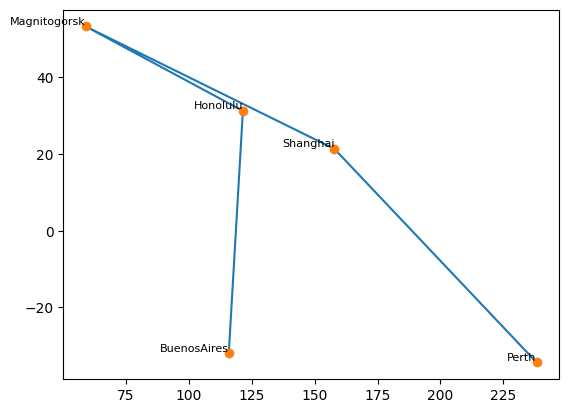

In [12]:
x_points = [cities.loc["Perth"]["X"], cities.loc["Shanghai"]["X"], cities.loc["Magnitogorsk"]["X"], cities.loc["Honolulu"]["X"], cities.loc["BuenosAires"]["X"]]
y_points = [cities.loc["Perth"]["Y"], cities.loc["Shanghai"]["Y"], cities.loc["Magnitogorsk"]["Y"], (-1)*cities.loc["Honolulu"]["Y"], 180-cities.loc["BuenosAires"]["Y"]]

plt.plot(y_points, x_points)
plt.plot(y_points, x_points, 'o')
for xi, yi, i in zip(y_points, x_points, list(range(len(city_list)))):
    plt.text(xi, yi, f'{city_list[sol[i]]}', fontsize=8, ha='right', va='bottom')

plt.show()

Теперь рассмотрим изменение решения посредством перебора кол-ва популяции

In [13]:
max_population_size = 40
tsp = TspAgent(matrix2d)
pops = []
sols_dists_1 = []

for population_size in range(2, max_population_size):
        population = tsp.generate_population(population_size=population_size)
        sol = tsp.genetic_search(population=population, calculate_fitness=tsp.calculate_fitness)
        pops.append(population_size)
        sols_dists_1.append(tsp.calculate_total_distance(sol))

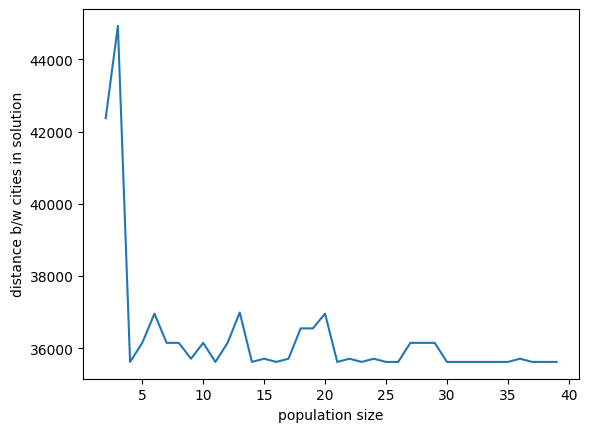

In [15]:
plt.plot(pops, sols_dists_1)
plt.xlabel('population size')
plt.ylabel('distance b/w cities in solution')
plt.show()

Сделаем то же самое, но для разного кол-ва поколений

In [17]:
max_generations = 300
tsp = TspAgent(matrix2d)
gens = []
sols_dists_2 = []

for generations in range(2, max_generations):
    population = tsp.generate_population()
    sol = tsp.genetic_search(population=population, calculate_fitness=tsp.calculate_fitness, generations=generations)
    gens.append(generations)
    sols_dists_2.append(tsp.calculate_total_distance(sol))

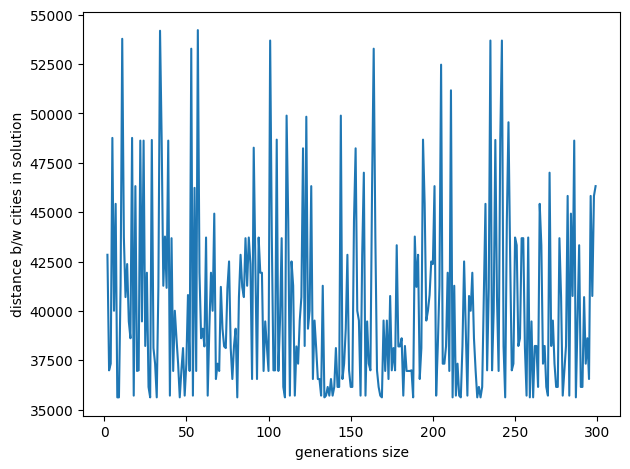

In [16]:
plt.plot(gens, sols_dists_2)
plt.xlabel('generations size')
plt.ylabel('distance b/w cities in solution')
plt.tight_layout()

Рассмотрев различные значения, можно сделать вывод, что при `population_size > 12` (или гарантированно при  `populations_size > 30`) расстояние достигает минимума, во всех этих случаях `max_generations = 50` по умолчанию. Если же наоборот фиксировать `population_size = 4` и задавать диапазон поколений до 300, то алгоритм ведет себя неустойчиво и не сходится